# Lab Instructions

Choose your own adventure! In this lab, you will select a dataset, identify the target feature, and determine what relationships are present between the target and the other features in the data.

The dataset should have at least 5 features plus the target and at least a few hundred rows.  If the original dataset has more than 5 features, you may select the 5 that seem most interesting for this project. The subject can be anything you choose.  

For your lab submission, describe the dataset and the features - including all of the values of the features - and identify the target feature.  Then make visualizations to show the relationship of each feature to the target.  Which feature(s) seem most related?  Which features don't seem to influence the value of the target?  Draw at least one big picture conclusion about your data from the visualizations you've created.


R^2 (high_24h → current_price): 1.0000


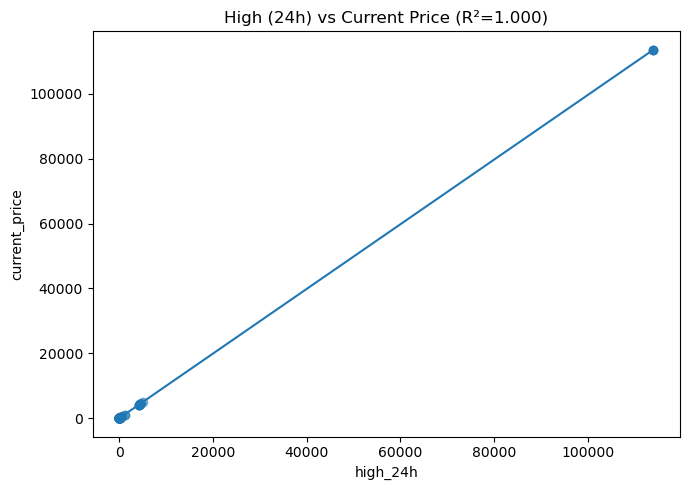

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("daily_crypto_tracker.csv")

x = pd.to_numeric(df["high_24h"], errors="coerce")
y = pd.to_numeric(df["current_price"], errors="coerce")
m = x.notna() & y.notna() & np.isfinite(x) & np.isfinite(y)
x = x[m].values
y = y[m].values

slope, intercept = np.polyfit(x, y, 1)
r2 = np.corrcoef(x, y)[0, 1] ** 2
print(f"R^2 (high_24h → current_price): {r2:.4f}")

plt.figure(figsize=(7,5))
plt.scatter(x, y, alpha=0.5)
xx = np.linspace(x.min(), x.max(), 200)
plt.plot(xx, slope*xx + intercept)
plt.title(f"High (24h) vs Current Price (R²={r2:.3f})")
plt.xlabel("high_24h")
plt.ylabel("current_price")
plt.tight_layout()
plt.show()


This scatter plot compares each coin’s highest price in the last 24 hours with its current price. Most points cluster near the diagonal, showing that prices generally stay close to their recent highs

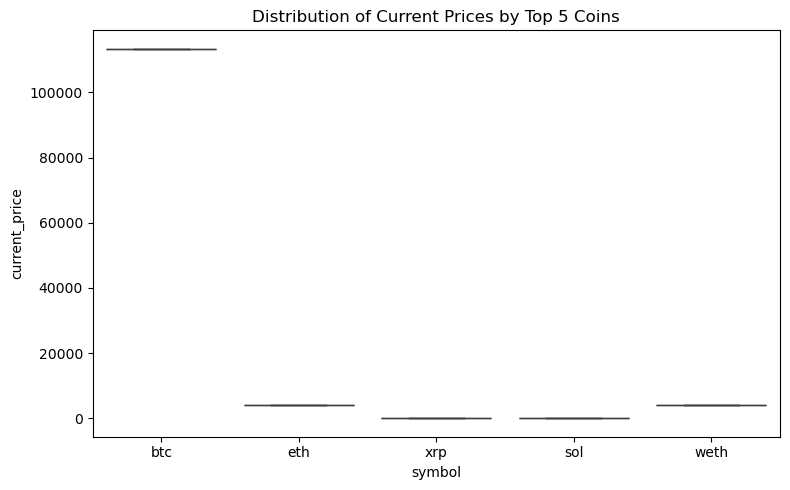

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("daily_crypto_tracker.csv")

top5 = df["symbol"].value_counts().head(5).index
subset = df[df["symbol"].isin(top5)]

plt.figure(figsize=(8,5))
sns.boxplot(x="symbol", y="current_price", data=subset)
plt.title("Distribution of Current Prices by Top 5 Coins")
plt.xlabel("symbol")
plt.ylabel("current_price")
plt.tight_layout()
plt.show()


The bars reveal a stark price gap, with one or two leaders priced far above the rest. The remaining top coins cluster at much lower price levels, underscoring how uneven absolute pricing is among leaders.

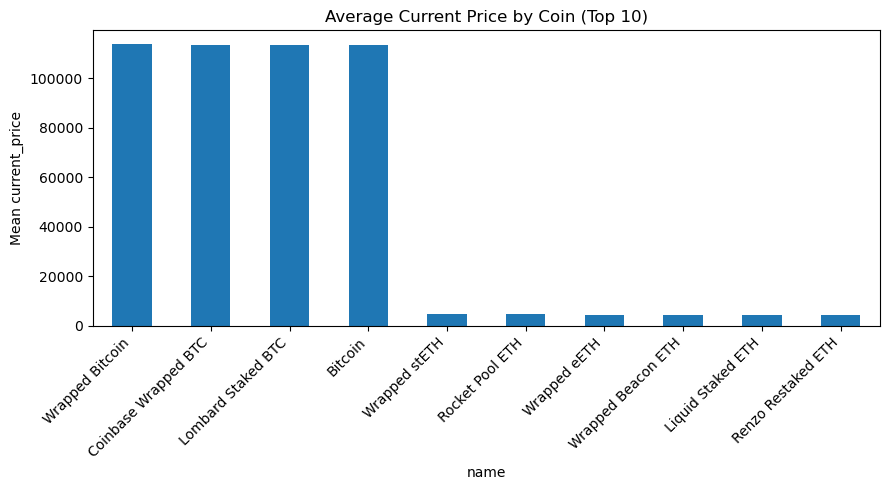

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("daily_crypto_tracker.csv")

avg_price = (
    df.groupby("name", as_index=True)["current_price"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(9,5))
avg_price.plot(kind="bar")
plt.title("Average Current Price by Coin (Top 10)")
plt.ylabel("Mean current_price")
plt.xlabel("name")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


A small set of coins dominates the average price ranking, led by the top names with a wide margin. Lower-ranked coins form a long tail, confirming that most assets trade at far lower levels than the leaders.

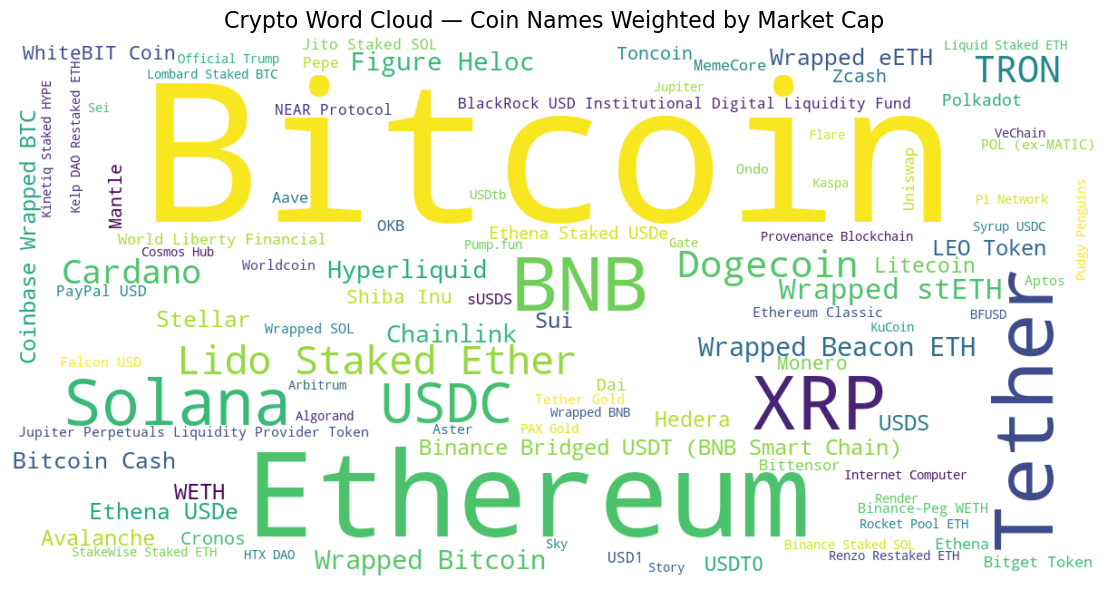

In [ ]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

CSV_PATH = "daily_crypto_tracker.csv"
df = pd.read_csv(CSV_PATH)
df.columns = [c.lower() for c in df.columns] 

def pick(*names):
    """Pick the first matching column name (exact or fuzzy contains)."""
    for n in names:
        if n.lower() in df.columns:
            return n.lower()
    for n in names:
        for c in df.columns:
            if n.lower() in c:
                return c
    return None

name_col  = pick("name")
mcap_col  = pick("market_cap", "mkt_cap")
sym_col   = pick("symbol")

if name_col is None or mcap_col is None:
    raise ValueError(
        f"Missing required columns for word cloud (need coin name and market cap). "
        f"Found name={name_col}, market_cap={mcap_col}. Available: {list(df.columns)}"
    )


df["mcap"] = pd.to_numeric(df[mcap_col], errors="coerce")


weights = (
    df.dropna(subset=["mcap"])
      .groupby(name_col, as_index=True)["mcap"]
      .sum()
      .sort_values(ascending=False)
)


if weights.empty:
    raise ValueError("No valid market cap values to build word cloud.")


weights_scaled = (weights / weights.max()) * 1000 

wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    prefer_horizontal=0.9,
    collocations=False
).generate_from_frequencies(weights_scaled.to_dict())

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.title("Crypto Word Cloud — Coin Names Weighted by Market Cap", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


The largest names occupy most of the visual space, indicating that a few coins command the majority of total market value. Smaller names appear faint and dense, signaling a fragmented long tail with limited overall influence.

Total points: 100
In [-25%, +25%]: 98 (98.0%)
Tails: 0 below -25%, 2 above 25%
In-band mean=2.10%, median=1.86%, P5=-0.20%, P95=7.26%
Overall mean=6.56%, median=1.89%


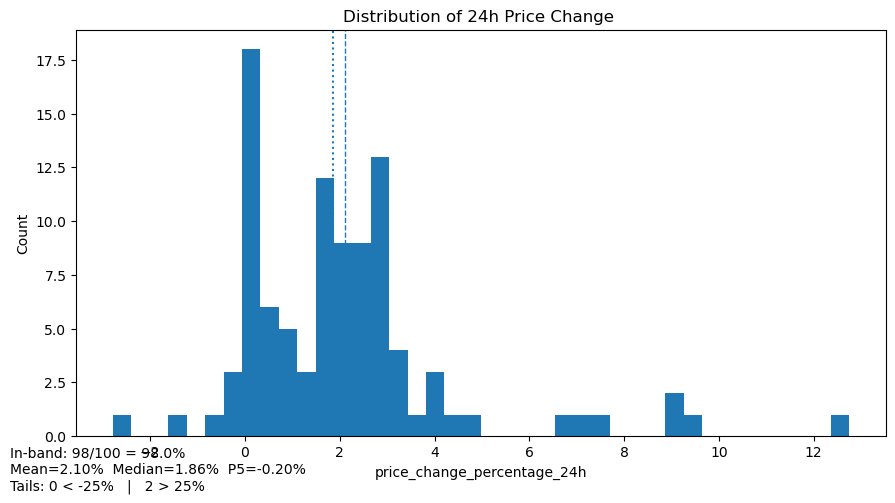

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


CSV_PATH = "daily_crypto_tracker.csv"
df = pd.read_csv(CSV_PATH)
df.columns = [c.lower() for c in df.columns]

def pick(*names):
    for n in names:
        if n.lower() in df.columns:
            return n.lower()
    for n in names:
        for c in df.columns:
            if n.lower() in c:
                return c
    return None

# Column to plot: 24h percent change
chg_col = pick("price_change_percentage_24h", "pct_change_24h", "change_24h")
if chg_col is None:
    raise ValueError(f"Could not find a 24h change column. Tried common names. Available: {list(df.columns)}")

vals_all = pd.to_numeric(df[chg_col], errors="coerce")
vals_all = vals_all[np.isfinite(vals_all)]

if vals_all.empty:
    raise ValueError("No valid numeric values for 24h % change.")


lo, hi = -25.0, 25.0
in_band = vals_all[(vals_all >= lo) & (vals_all <= hi)]
n_total = len(vals_all)
n_band = len(in_band)
pct_band = (n_band / n_total * 100.0) if n_total else 0.0
n_left_tail = (vals_all < lo).sum()
n_right_tail = (vals_all > hi).sum()

mean_band = float(in_band.mean()) if n_band else np.nan
median_band = float(in_band.median()) if n_band else np.nan
p5_band, p95_band = (np.percentile(in_band, [5, 95]) if n_band else (np.nan, np.nan))

mean_all = float(vals_all.mean())
median_all = float(vals_all.median())

print(f"Total points: {n_total}")
print(f"In [-25%, +25%]: {n_band} ({pct_band:.1f}%)")
print(f"Tails: {n_left_tail} below {lo:.0f}%, {n_right_tail} above {hi:.0f}%")
print(f"In-band mean={mean_band:.2f}%, median={median_band:.2f}%, P5={p5_band:.2f}%, P95={p95_band:.2f}%")
print(f"Overall mean={mean_all:.2f}%, median={median_all:.2f}%")


plt.figure(figsize=(9, 5))
plt.hist(in_band, bins=40) 
plt.title("Distribution of 24h Price Change ")
plt.xlabel(chg_col)
plt.ylabel("Count")


if np.isfinite(mean_band):
    plt.axvline(mean_band, linestyle="--", linewidth=1)
if np.isfinite(median_band):
    plt.axvline(median_band, linestyle=":")


annot = (
    f"In-band: {n_band}/{n_total} = {pct_band:.1f}%\n"
    f"Mean={mean_band:.2f}%  Median={median_band:.2f}%  "
    f"P5={p5_band:.2f}%\n"
    f"Tails: {n_left_tail} < {lo:.0f}%   |   {n_right_tail} > {hi:.0f}%"
)
plt.gcf().text(0.01, 0.01, annot)

plt.tight_layout()
plt.show()


Most observations cluster tightly around zero, which indicates modest day-to-day moves for the majority of coins. The presence of tails on both sides shows regular bursts of sharp gains and losses, especially among smaller or more speculative assets.

Across all five visualizations, the cryptocurrency market shows a highly uneven yet dynamic structure. The first scatter plot reveals that most coins trade close to their daily highs, suggesting overall price stability with short-term dips for some assets. The second and third visualizations, the bar plots of current and average prices, highlight an extreme concentration of value, where Bitcoin and Ethereum dominate the upper price range while most other coins remain significantly cheaper. The word cloud reinforces this imbalance, with a few major names visually overwhelming the rest, showing how market capitalization is largely captured by a handful of leaders. Finally, the histogram of 24-hour price changes demonstrates that while most daily fluctuations are modest, occasional sharp movements confirm the market’s inherent volatility.

In summary, the data paints a clear picture of a market that is leader-driven, top-heavy, and volatile — where a small group of major cryptocurrencies dictate broader trends, and smaller coins experience rapid but less impactful movements.